## Introductory Overview of PyMC

https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html

## A Motivating Example: Linear Regression



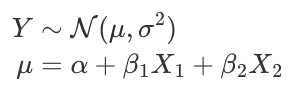


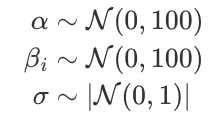

## Setting up PyMC3

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Generating data


In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

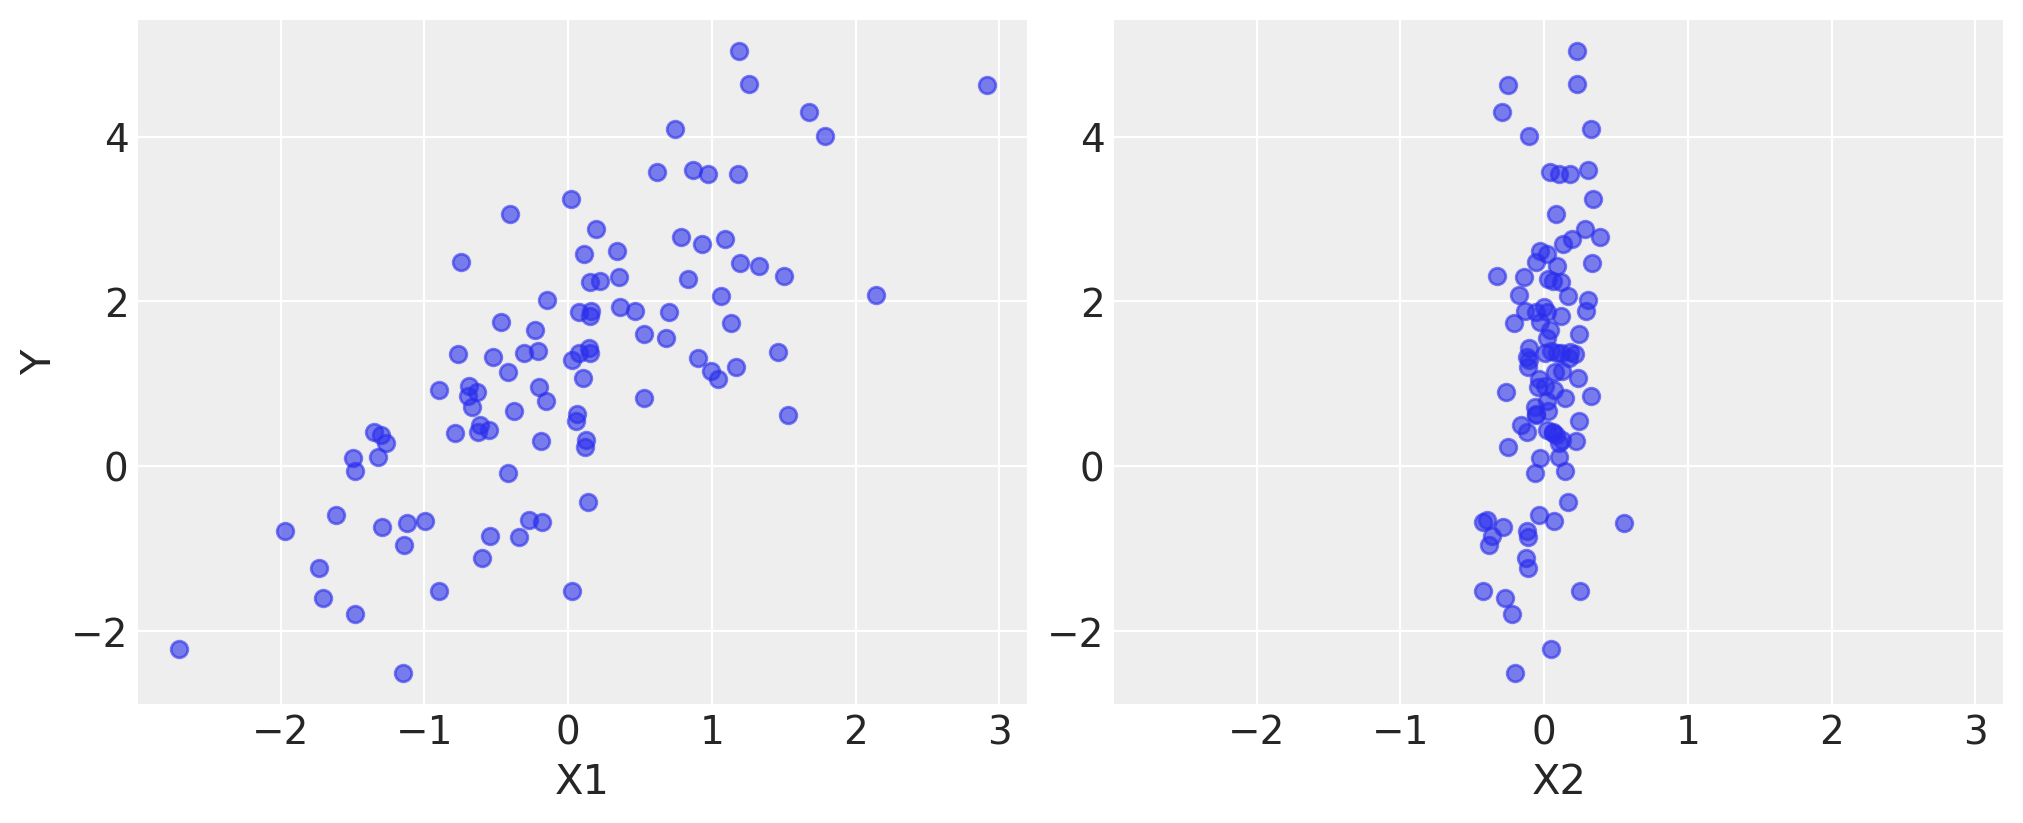

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

## Model Specification


In [5]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.0.1


In [6]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [7]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [8]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[1.2488847 , 1.18000007, 1.18926948, 1.14909552, 1.12352147],
       [1.1454017 , 1.16394384, 1.24502076, 1.15740906, 1.16210723],
       [1.12391089, 1.22239616, 1.22239616, 1.23111119, 1.0047976 ],
       [1.08642237, 1.21166956, 1.07615697, 1.18571244, 1.11303954]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

In [10]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.


## Posterior analysis


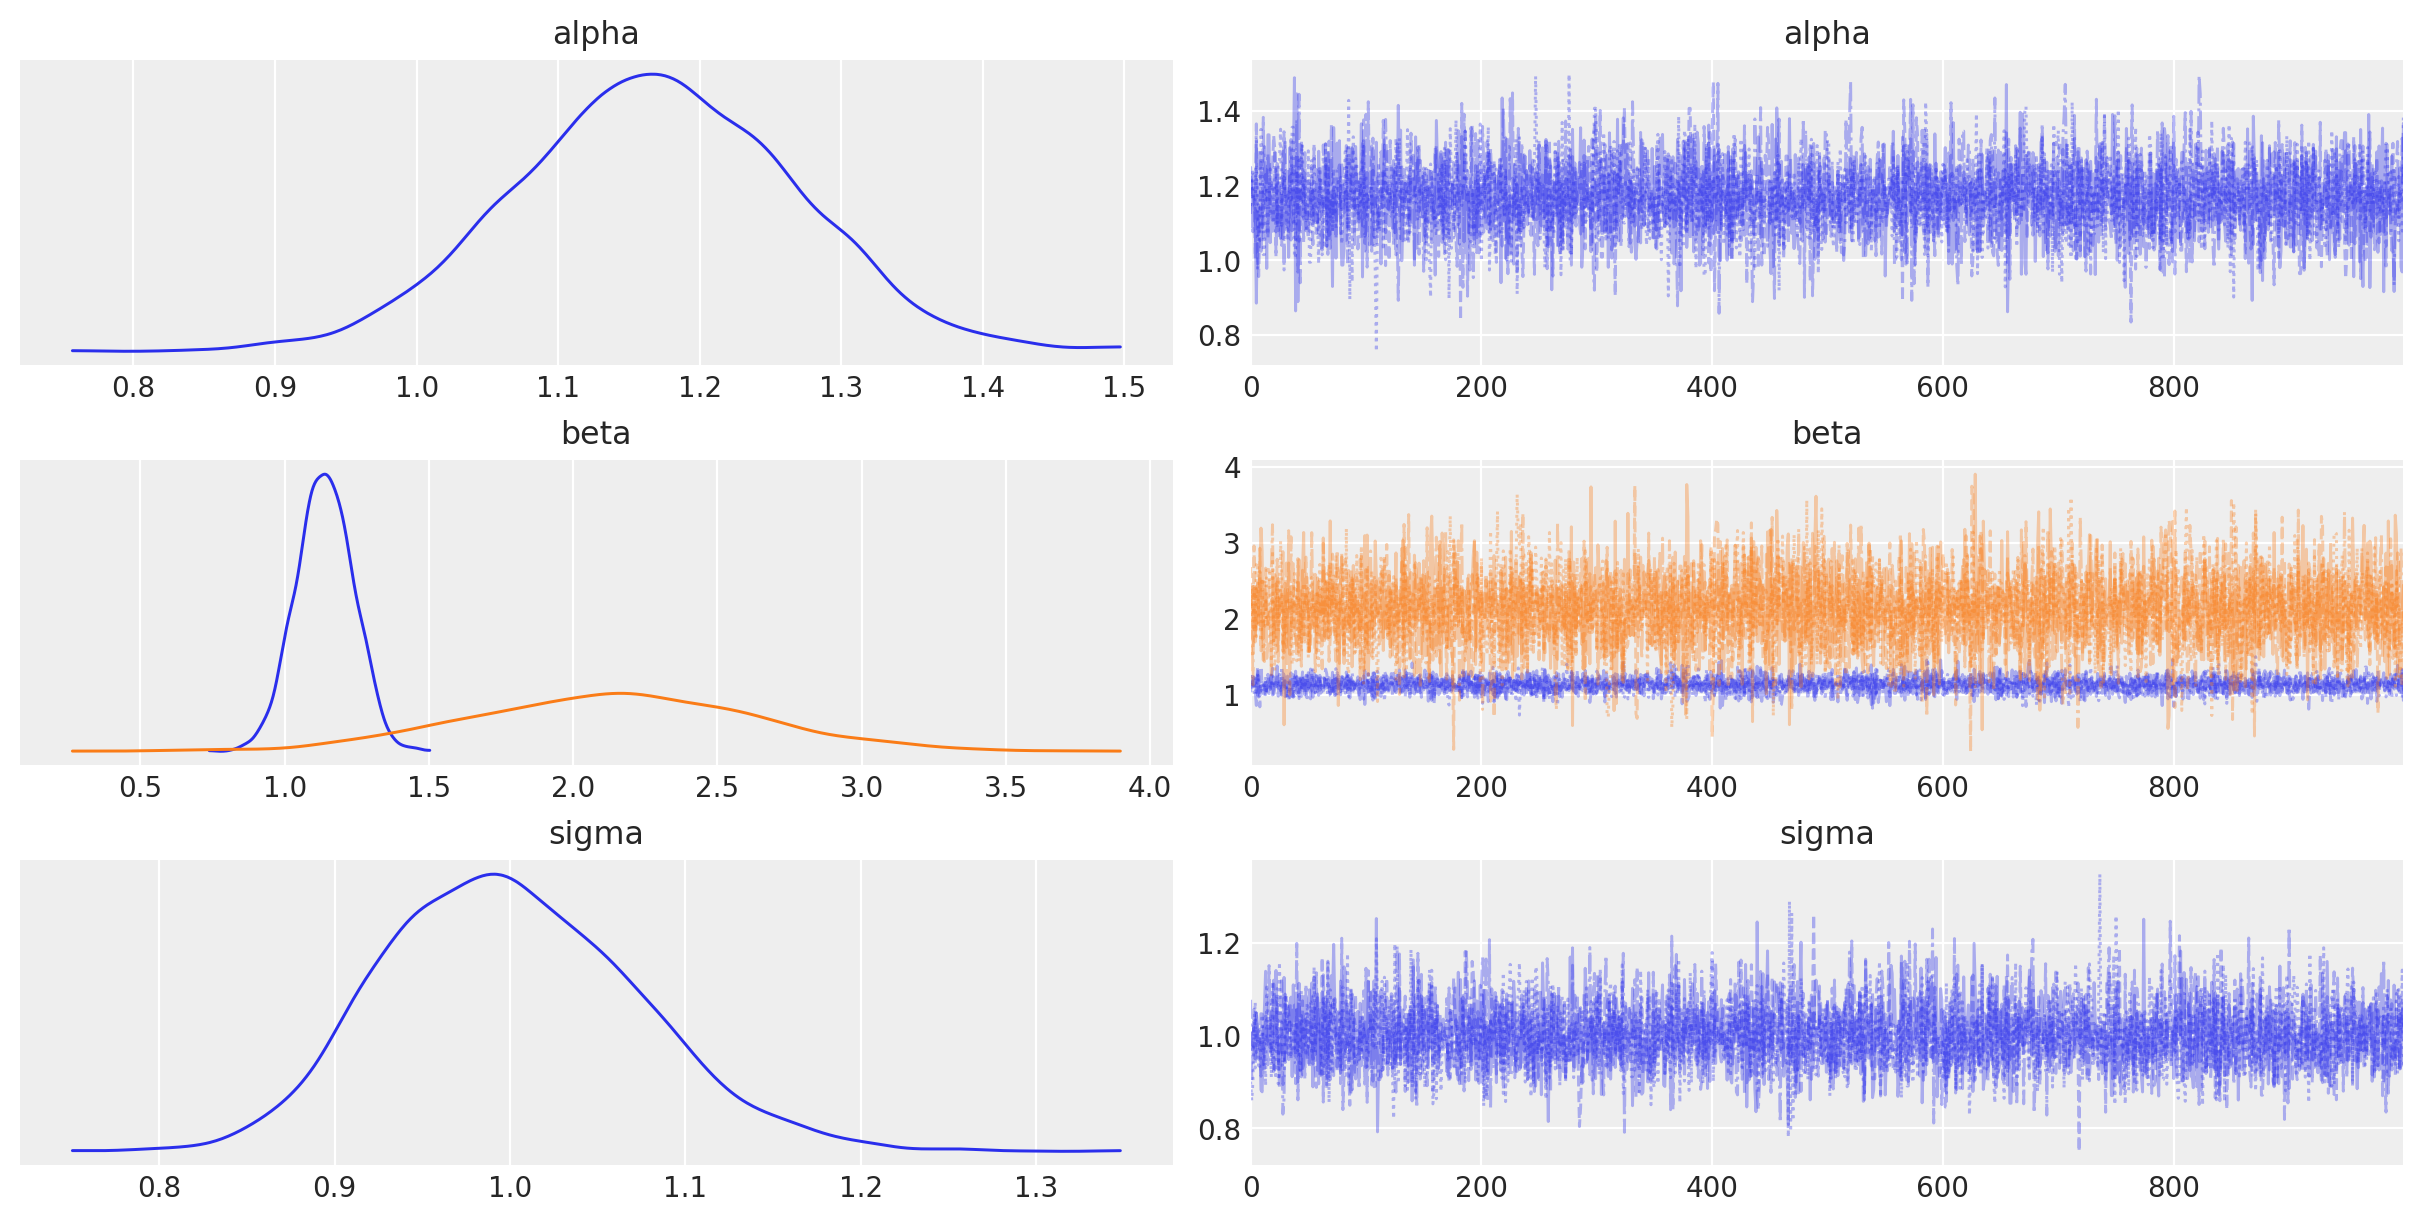

In [11]:
az.plot_trace(idata, combined=True);

In [12]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.17,0.10,0.99,1.35,0.00,0.0,5861.23,3208.27,1.0
beta[0],1.14,0.10,0.97,1.33,0.00,0.0,5454.20,3285.45,1.0
beta[1],2.14,0.50,1.20,3.07,0.01,0.0,5365.17,3249.95,1.0
sigma,1.00,0.07,0.87,1.14,0.00,0.0,5597.73,3275.08,1.0


In [13]:
Y_obs

Y_obs

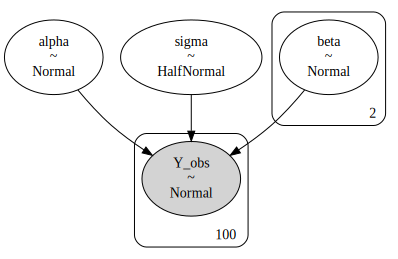

In [14]:
pm.model_to_graphviz(basic_model)

In [15]:
# testing github

# Logistic regression with PyMC3

In [16]:
import os
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
#import theano.tensor as tt
import warnings
from IPython.core.pylabtools import figsize
import seaborn as sns
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 
from sklearn.metrics import confusion_matrix

In [17]:
os.getcwd()

'/home/yako/Desktop/TAMU_STAT/STAT685_Direct Studies/STAT685_GitProject'

In [19]:
df=pd.read_csv('/home/yako/Desktop/TAMU_STAT/STAT685_Direct Studies/STAT685_GitProject/occupancy_data/datatest.txt')
df.sample(5)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
768,2015-02-03 00:47:00,20.5500,22.290000,0.0,447.000000,0.003328,0
619,2015-02-02 22:18:00,20.7225,22.550000,0.0,460.500000,0.003404,0
576,2015-02-02 21:35:00,20.8900,22.890000,0.0,480.000000,0.003491,0
918,2015-02-03 03:16:59,20.5000,22.390000,0.0,434.500000,0.003333,0
1265,2015-02-03 09:04:00,21.0000,24.963333,444.0,742.333333,0.003835,1


In [20]:
df['date']=pd.to_datetime(df['date'])


In [21]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
mean,21.433876,25.353937,193.227556,717.906470,0.004027,0.364728
std,1.028024,2.436842,250.210906,292.681718,0.000611,0.481444
min,20.200000,22.100000,0.000000,427.500000,0.003303,0.000000
25%,20.650000,23.260000,0.000000,466.000000,0.003529,0.000000
50%,20.890000,25.000000,0.000000,580.500000,0.003815,0.000000
75%,22.356667,26.856667,442.500000,956.333333,0.004532,1.000000
max,24.408333,31.472500,1697.250000,1402.250000,0.005378,1.000000


In [22]:
df['date'].describe()

/tmp/ipykernel_87087/801468514.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['date'].describe()


count                    2665
unique                   2665
top       2015-02-02 14:19:00
freq                        1
first     2015-02-02 14:19:00
last      2015-02-04 10:43:00
Name: date, dtype: object

### The first model with priors having uniform distributions

In [24]:
lower=-10**6
higher=10**6
with pm.Model() as first_model:
    #priors on parameters
    beta_0=pm.Uniform('beta_0', lower=lower, upper= higher)
    beta_temp=pm.Uniform('beta_temp', lower, higher)
    beta_humid=pm.Uniform('beta_humid', lower, higher)
    beta_light=pm.Uniform('beta_light', lower, higher)
    beta_co2=pm.Uniform('beta_co2', lower, higher)
    beta_humid_ratio=pm.Uniform('beta_humid_ration', lower, higher)
    
    #the probability of belonging to class 1
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_temp*df['Temperature']+
                               beta_humid*df['Humidity']+
                               beta_light*df['Light']+
                               beta_co2*df['CO2']+
                               beta_humid_ratio*df['HumidityRatio']))
with first_model:
    #fit the data 
    observed=pm.Bernoulli("occupancy", p, observed=df['Occupancy'])
    start=pm.find_MAP()
    step=pm.Metropolis()
    
    #samples from posterior distribution 
    trace=pm.sample(25000, step=step, start=start)
    #burned_trace=trace[15000:]

/tmp/ipykernel_87087/2489479671.py:25: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace=pm.sample(25000, step=step, start=start)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_0]
>Metropolis: [beta_temp]
>Metropolis: [beta_humid]
>Metropolis: [beta_light]
>Metropolis: [beta_co2]
>Metropolis: [beta_humid_ration]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 78 seconds.


KeyError: slice(15000, None, None)

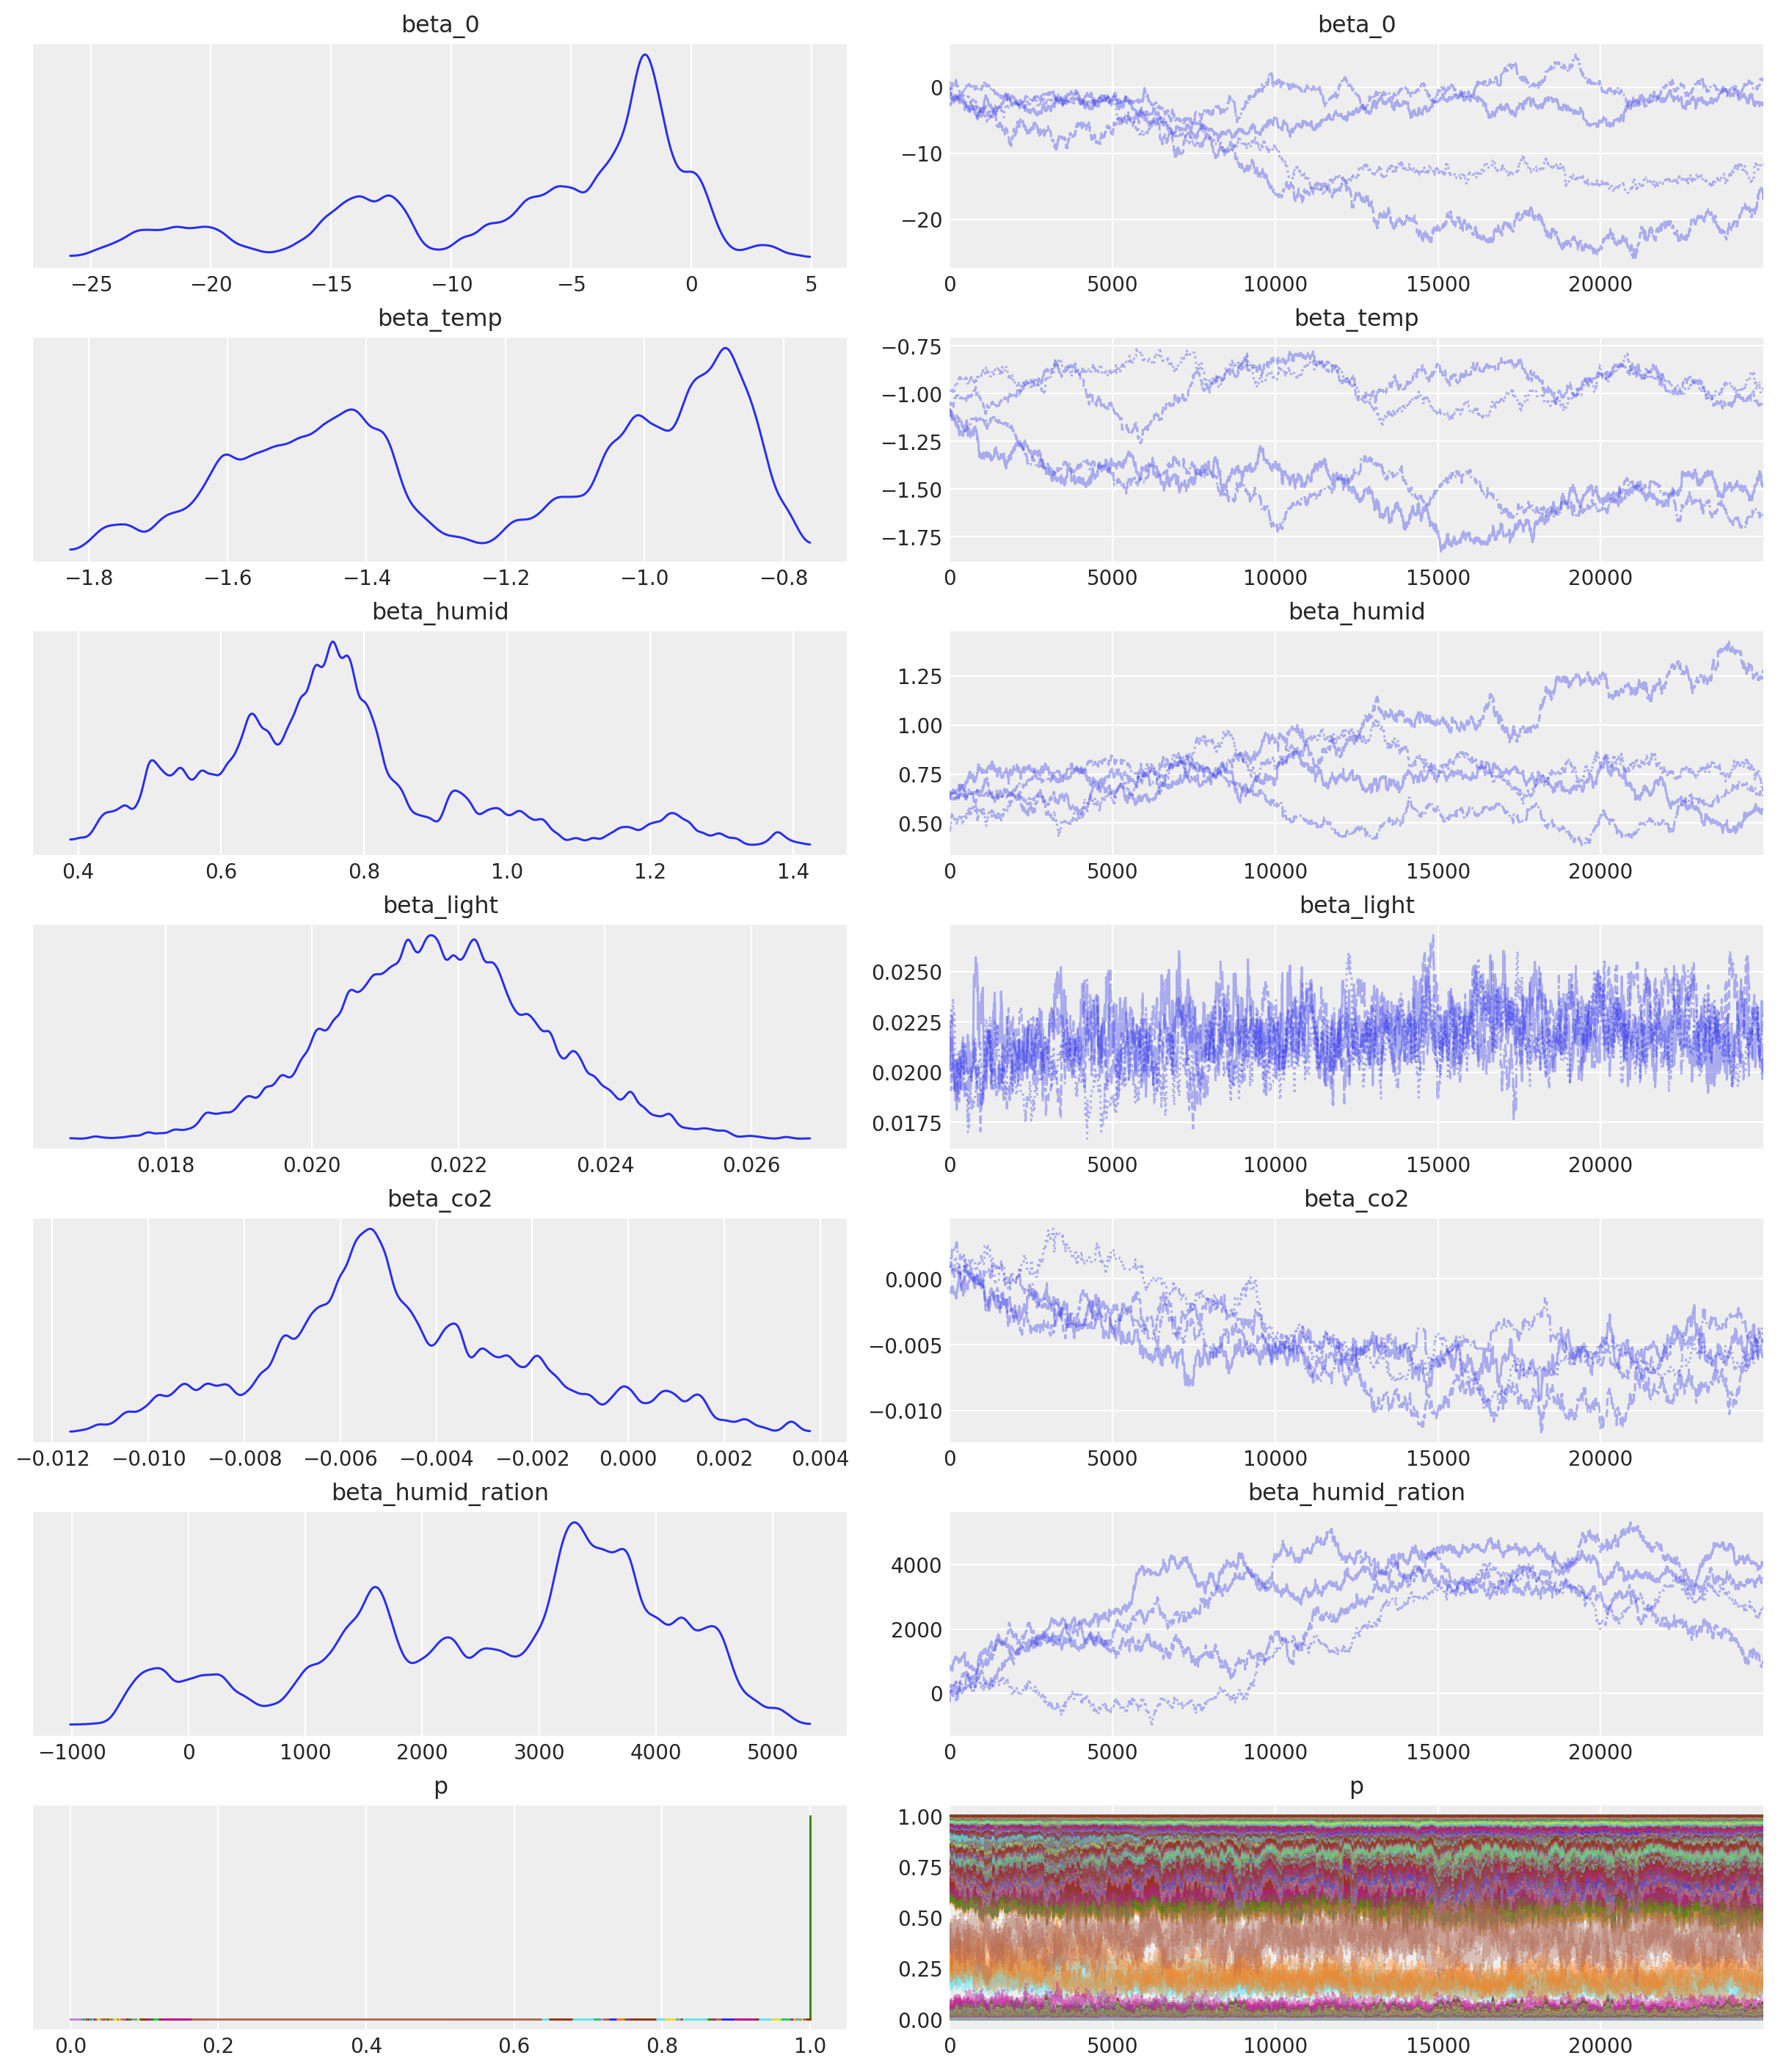

In [27]:
az.plot_trace(trace, combined=True);